In [1]:
#load packages

import math, time
import torch
import os
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
import numpy as np


In [2]:
exptnames = ['ReLU', 'JumpReLU', 'TopK', 'SpaDE']
results_all = []
for i in range(len(exptnames)):
    results_all.append(torch.load('./results2/'+exptnames[i]+'_results.pt', map_location=torch.device('cpu')))

/tmp/ipykernel_3361224/2574205173.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results_all.append(torch.load('./results2/'+exptnames[i]+'_results.pt', map_location=to

In [3]:
results_all[0]['sae_decoder_bias'].shape

torch.Size([1, 128])

In [4]:
#load data subset
data_subset = []
labels_subset = []
numpoints_perconc = []
concept_names = []
for lab, key in enumerate(results_all[0]['pos_acts'].keys()):
    concept_names.append(key)
    data_subset.append(results_all[0]['pos_acts'][key])
    numpoints_perconc.append(data_subset[lab].shape[0])
    labels_subset.append(lab*torch.ones((numpoints_perconc[-1],)))
data_subset = torch.cat(data_subset, dim=0)
labels_subset = torch.cat(labels_subset)
num_concepts = len(concept_names)

In [5]:
#pca of data_subset
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(data_subset)
data_subset_pca = pca.transform(data_subset)
encweightspca = [pca.transform(results_all[i]['sae_encoder_weights'].detach().numpy()) for i in range(len(exptnames))]
preencbiaspca = [pca.transform(results_all[i]['sae_decoder_bias'].detach().numpy()) for i in range(len(exptnames))]

In [6]:
# #do kernel density estimation on data_subset_pca
# from sklearn.neighbors import KernelDensity
# from scipy.stats import gaussian_kde
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import LeaveOneOut
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score

# # Use a separate KDE for each cluster identified by labels_subset
# dens = np.zeros(data_subset_pca.shape[0])
# for label in np.unique(labels_subset):
#     cluster_data = data_subset_pca[labels_subset == label]
#     grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths})
#     grid.fit(cluster_data)
#     kde = grid.best_estimator_
#     log_dens = kde.score_samples(cluster_data)
#     dens[labels_subset == label] = np.exp(log_dens)

# # Normalize the density
# dens = dens / np.max(dens)

# # Create a 3D grid of points to evaluate the density
# x_min, x_max = data_subset_pca[:, 0].min() - 1, data_subset_pca[:, 0].max() + 1
# y_min, y_max = data_subset_pca[:, 1].min() - 1, data_subset_pca[:, 1].max() + 1
# z_min, z_max = data_subset_pca[:, 2].min() - 1, data_subset_pca[:, 2].max() + 1
# xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, 100), 
#                          np.linspace(y_min, y_max, 100), 
#                          np.linspace(z_min, z_max, 100))
# grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]

# # Evaluate the density on the grid for each cluster and sum them
# dens_grid = np.zeros(xx.shape)
# for label in np.unique(labels_subset):
#     cluster_data = data_subset_pca[labels_subset == label]
#     grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths})
#     grid.fit(cluster_data)
#     kde = grid.best_estimator_
#     log_dens_grid = kde.score_samples(grid_points)
#     dens_grid += np.exp(log_dens_grid).reshape(xx.shape)

In [7]:
# import seaborn as sns
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# colors = plt.cm.Spectral(np.linspace(0, 1, len(np.unique(labels_subset))))

# for label, color in zip(np.unique(labels_subset), colors):
#     cluster_data = data_subset_pca[labels_subset == label]
#     grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths})
#     grid.fit(cluster_data)
#     kde = grid.best_estimator_
#     log_dens_grid = kde.score_samples(grid_points)
#     dens_grid = np.exp(log_dens_grid).reshape(xx.shape)
    
#     # Plot contours
#     sns.kdeplot(x=grid_points[:, 0], y=grid_points[:, 1], z=grid_points[:, 2], levels=10, color=color, ax=ax)

#     # Scatter plot
#     ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], color=color, alpha=0.5, s=5)

# ax.set_xlabel('PCA1')
# ax.set_ylabel('PCA2')
# ax.set_zlabel('PCA3')
# ax.set_title('Density of data points in PCA space')
# plt.show()


In [8]:
#load latent reps
latent_reps_all = []
for i in range(len(exptnames)):
    latentsi = []
    for lab,key in enumerate(results_all[i]['latents_to_acts'].keys()):
        latentsi.append(results_all[i]['latents_to_acts'][key])
    latent_reps_all.append(torch.cat(latentsi, dim=0))

In [9]:
#identify concept which latent activates most for
classavg_reps = [torch.zeros(num_concepts, latent_reps_all[i].shape[-1]) for i in range(len(exptnames))]
for i in range(len(exptnames)):
    for c in range(num_concepts):
        classavg_reps[i][c] = torch.mean(latent_reps_all[i][labels_subset==c, :], dim=0)    
order_by_concept_all = []
concepts_of_latents_all = []
concepts_ordered_all = []
numlatents_perconc_all = []
for i in range(len(exptnames)):
    concepts_of_latents = torch.argmax(classavg_reps[i], dim=0) #gives indices of concepts with max value in each latent dimension
    order_by_concept = torch.argsort(concepts_of_latents) #sorts latents by concept
    order_by_concept_all.append(order_by_concept)
    concepts_of_latents_all.append(concepts_of_latents)
    concepts_ordered_all.append(concepts_of_latents[order_by_concept])
    numlatents_perconc_all.append([torch.sum(concepts_of_latents==c).item() for c in range(num_concepts)])


In [10]:
Cdata_all = []
Clatent_all = []
for i in range(len(exptnames)):
    Cdata_all.append(results_all[i]['acts_corrmap'])
    clatent = results_all[i]['latents_corrmap']
    clatent = clatent[order_by_concept_all[i], :]
    clatent = clatent[:, order_by_concept_all[i]]
    Clatent_all.append(clatent)

In [11]:
# #alter- do spectral clustering on latents

# stableranks = []
# for i in range(len(exptnames)):
#     sr = torch.trace(Clatent_all[i])/torch.linalg.matrix_norm(Clatent_all[i], ord=2)
#     stableranks.append(sr.item())

# from sklearn.cluster import spectral_clustering as sc

# latent_order_all_sc = []
# sc_labels_all = []
# for i in range(len(exptnames)):
#     n_clusters = math.ceil(stableranks[i])
#     labels = sc(Clatent_all[i].cpu().numpy(), n_clusters=n_clusters, random_state=0)
#     labels = torch.tensor(labels)
#     sc_labels_all.append(labels)
#     order = torch.argsort(labels)
#     latent_order_all_sc.append(order)

# #for every experiment, for every label (group of latents), get the maximally activating concept
# concept_maxact_all = []
# for i in range(len(exptnames)):
#     nclusters_sc = math.ceil(stableranks[i])
#     concept_maxact = torch.zeros((nclusters_sc,))
#     for c in range(nclusters_sc):
#         concept_maxact[c] = 0
#         for q in range(num_concepts):
#             act_concq = torch.mean(latent_reps_all[i][:, sc_labels_all[i]==c], dim=-1)[labels_subset==q].mean()
#             if act_concq > concept_maxact[c]:
#                 concept_maxact[c] = q
#     concept_maxact_all.append(concept_maxact)

In [12]:
# Clatent_sc_all = []
# for i in range(len(exptnames)):
#     clatent = Clatent_all[i][latent_order_all_sc[i], :]
#     clatent = clatent[:, latent_order_all_sc[i]]
#     Clatent_sc_all.append(clatent)

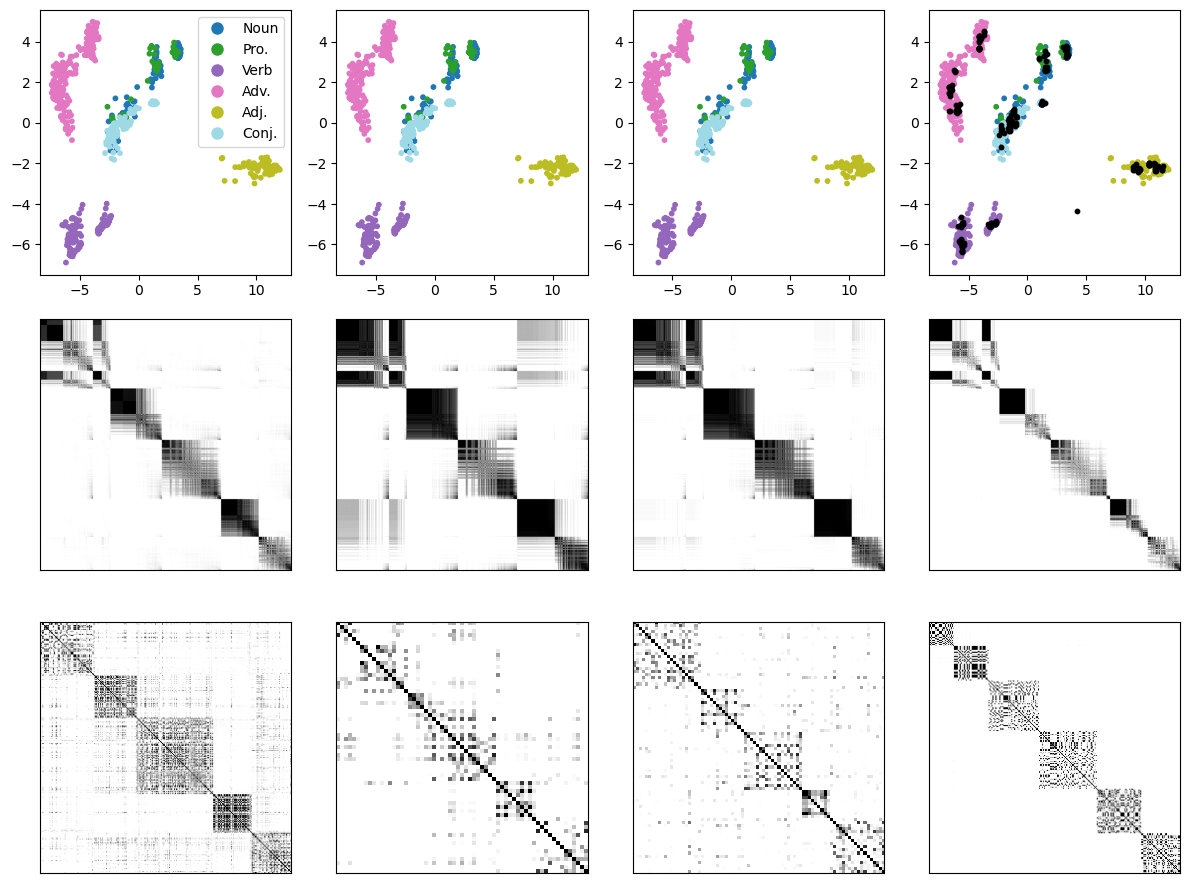

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(3*4, 3*3))
ax = ax.T
# cmap = plt.cm.rainbow
# colors_concepts = [cmap.colors[i] for i in range(num_concepts)]
# get 10 colors from a colormap
cmap = plt.get_cmap('tab20')
import numpy as np
# Generate 10 evenly spaced colors
colors_concepts = [cmap(i) for i in np.linspace(0, 1, num_concepts)]
for i in range(len(exptnames)):
    ax[i,0].scatter(data_subset_pca[:,0], data_subset_pca[:,1], c=[colors_concepts[int(labels_subset[j].item())] for j in range(len(labels_subset))], s=10)
    if i==len(exptnames)-1:
        ax[i,0].scatter(encweightspca[i][:,0], encweightspca[i][:,1], c='black', s=10)
    else:
        ax[i,0].quiver(torch.zeros((encweightspca[i].shape[0],)), torch.zeros((encweightspca[i].shape[0],)), encweightspca[i][:,0], encweightspca[i][:,1], color='black')
    ax[i, 1].imshow(Cdata_all[i].detach().cpu(), cmap='binary', vmin=0, vmax=1)
    # ax[i,1].hlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[1], colors='r', linewidth=2)
    # ax[i,1].vlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[0], colors='r', linewidth=2)
    ax[i, 2].imshow(Clatent_all[i].detach().cpu(), cmap='binary', vmin=0, vmax=1)
    # ax[i,2].hlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[1], colors='r', linewidth=2)
    # ax[i,2].vlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[0], colors='r', linewidth=2)
    # ax[i,0].set_xticks([])
    # ax[i,0].set_yticks([])
    # ax[i, 1].axis('off')
    # ax[i, 2].axis('off')
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
    ax[i,2].set_xticks([])
    ax[i,2].set_yticks([])
    if i==0:
        #add custom legend with points with concept names and colors
        custom_points = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_concepts[c], markersize=10) for c in range(num_concepts)]
        ax[i,0].legend(custom_points, concept_names, loc='upper right')

fig.tight_layout()
# plt.savefig('./figs/formallanguagefig.pdf',dpi=300,bbox_inches='tight')

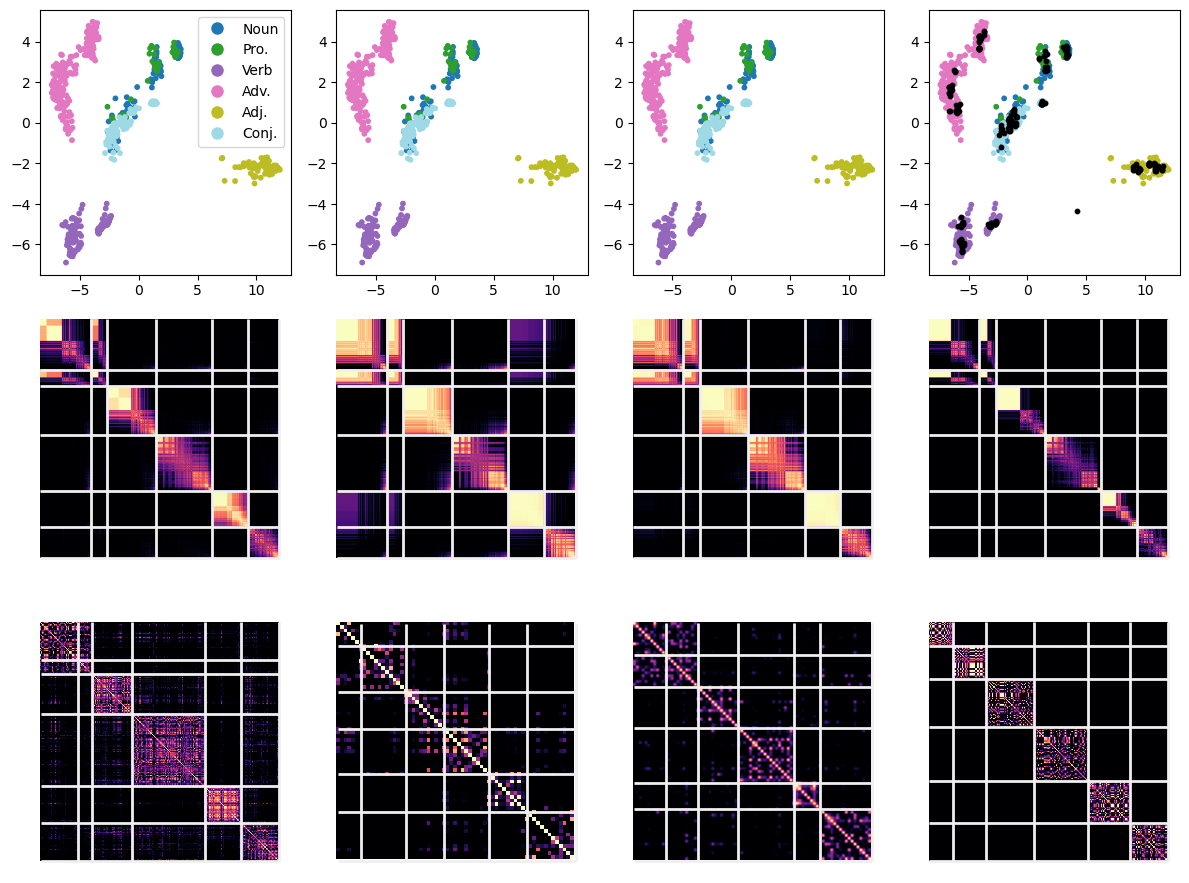

In [14]:
fig, ax = plt.subplots(3, 4, figsize=(3*4, 3*3))
ax = ax.T
# cmap = plt.cm.rainbow
# colors_concepts = [cmap.colors[i] for i in range(num_concepts)]
# get 10 colors from a colormap
cmap = plt.get_cmap('tab20')
import numpy as np
# Generate 10 evenly spaced colors
colors_concepts = [cmap(i) for i in np.linspace(0, 1, num_concepts)]
for i in range(len(exptnames)):
    ax[i,0].scatter(data_subset_pca[:,0], data_subset_pca[:,1], c=[colors_concepts[int(labels_subset[j].item())] for j in range(len(labels_subset))], s=10)
    if i==len(exptnames)-1:
        ax[i,0].scatter(encweightspca[i][:,0], encweightspca[i][:,1], c='black', s=10)
    # else:
    #     ax[i,0].quiver(torch.zeros((encweightspca[i].shape[0],)), torch.zeros((encweightspca[i].shape[0],)), encweightspca[i][:,0], encweightspca[i][:,1], color='black')
    ax[i, 1].imshow(Cdata_all[i].detach().cpu(), cmap='magma', vmin=0, vmax=1)
    ax[i,1].hlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[1], colors='#EFEFEF', linewidth=2)
    ax[i,1].vlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[0], colors='#EFEFEF', linewidth=2)
    ax[i, 2].imshow(Clatent_all[i].detach().cpu(), cmap='magma', vmin=0, vmax=1)
    ax[i,2].hlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[1], colors='#EFEFEF', linewidth=2)
    ax[i,2].vlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[0], colors='#EFEFEF', linewidth=2)
    # ax[i,0].set_xticks([])
    # ax[i,0].set_yticks([])
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    # ax[i,1].set_xticks([])
    # ax[i,1].set_yticks([])
    # ax[i,2].set_xticks([])
    # ax[i,2].set_yticks([])
    if i==0:
        #add custom legend with points with concept names and colors
        custom_points = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_concepts[c], markersize=10) for c in range(num_concepts)]
        ax[i,0].legend(custom_points, concept_names, loc='upper right')

fig.tight_layout()
# plt.savefig('./figs/formallanguagefig.pdf',dpi=300,bbox_inches='tight')

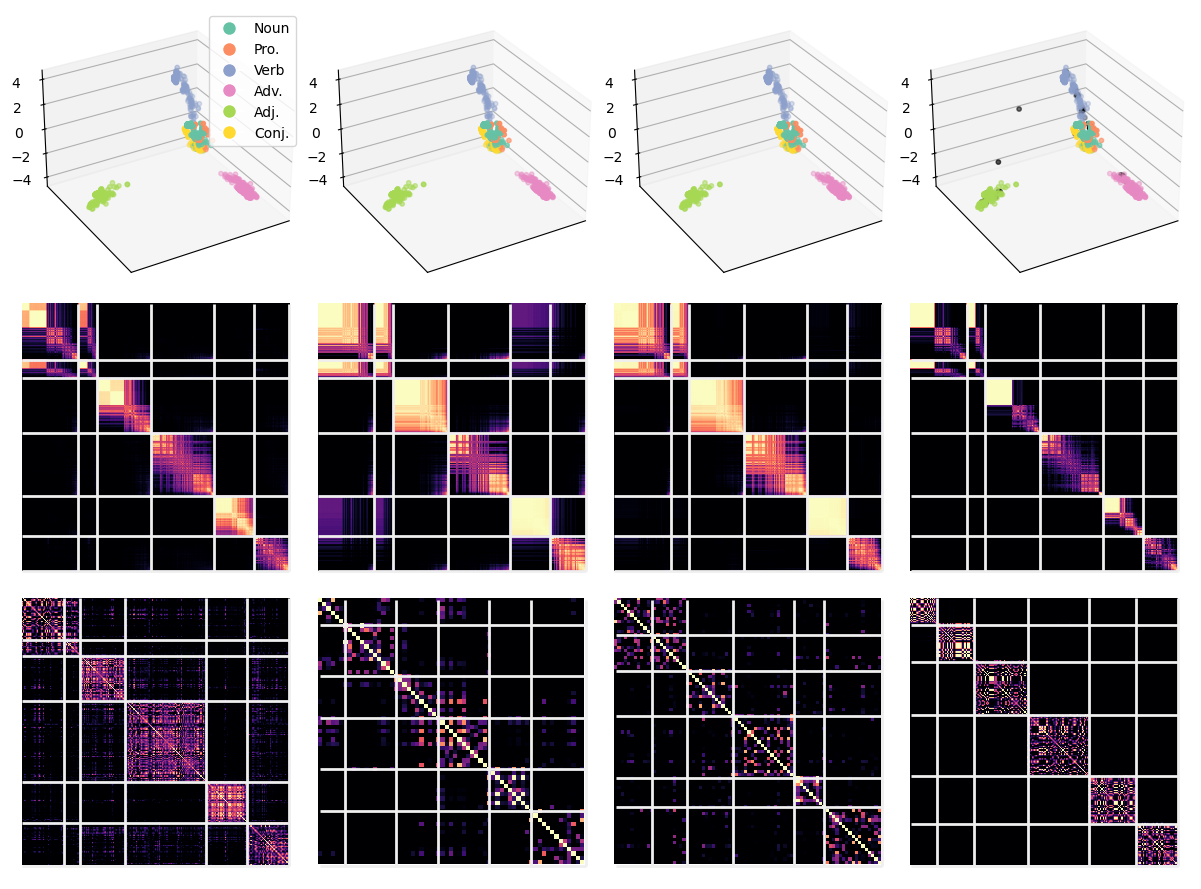

In [26]:
# fig, ax = plt.subplots(len(exptnames), 3, figsize=(3*3, 3*len(exptnames)))

fig = plt.figure(figsize=(3*4, 3*3))

ax1 = plt.subplot2grid((3, 4), (0, 0), rowspan=1, colspan=1, projection='3d')
ax2 = plt.subplot2grid((3, 4), (1, 0), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((3, 4), (2, 0), rowspan=1, colspan=1)

ax4 = plt.subplot2grid((3, 4), (0, 1), rowspan=1, colspan=1, projection='3d')
ax5 = plt.subplot2grid((3, 4), (1, 1), rowspan=1, colspan=1)
ax6 = plt.subplot2grid((3, 4), (2, 1), rowspan=1, colspan=1)

ax7 = plt.subplot2grid((3, 4), (0, 2), rowspan=1, colspan=1, projection='3d')
ax8 = plt.subplot2grid((3, 4), (1, 2), rowspan=1, colspan=1)
ax9 = plt.subplot2grid((3, 4), (2, 2), rowspan=1, colspan=1)

ax10 = plt.subplot2grid((3, 4), (0, 3), rowspan=1, colspan=1, projection='3d')
ax11 = plt.subplot2grid((3, 4), (1, 3), rowspan=1, colspan=1)
ax12 = plt.subplot2grid((3, 4), (2, 3), rowspan=1, colspan=1)

ax = np.array([[ax1, ax4, ax7, ax10], [ax2, ax5, ax8, ax11], [ax3, ax6, ax9, ax12]])
ax = ax.T
cmap = plt.cm.Set2
colors_concepts = [cmap.colors[i] for i in range(num_concepts)]

for i in range(len(exptnames)):
    ax[i,0].scatter(data_subset_pca[:,0], data_subset_pca[:,1], data_subset_pca[:,2], \
        c=[colors_concepts[int(labels_subset[i].item())] for i in range(len(labels_subset))], s=10)
    ax[i,0].view_init(elev=30, azim=60)
    if i==len(exptnames)-1:
        ax[i,0].scatter(encweightspca[i][:,0], encweightspca[i][:,1], encweightspca[i][:,2], c='black', s=10)
        ax[i,0].view_init(elev=30, azim=60)
    # else:
        # ax[i,0].quiver(preencbiaspca[i][0,0]*np.ones((encweightspca[i].shape[0],)), \
        #     preencbiaspca[i][0,1]*np.ones((encweightspca[i].shape[0],)), \
        #         preencbiaspca[i][0,2]*np.ones((encweightspca[i].shape[0],)), \
        #             encweightspca[i][:,0], encweightspca[i][:,1], encweightspca[i][:,2], \
        #                 color='black', length=0.02, arrow_length_ratio=0.1)
    ax[i, 1].imshow(Cdata_all[i], cmap='magma', vmin=0, vmax=1)
    ax[i,1].hlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[1], colors='#EFEFEF', linewidth=2)
    ax[i,1].vlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[0], colors='#EFEFEF', linewidth=2)
    ax[i, 2].imshow(Clatent_all[i], cmap='magma', vmin=0, vmax=1)
    ax[i,2].hlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[1], colors='#EFEFEF', linewidth=2)
    ax[i,2].vlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[0], colors='#EFEFEF', linewidth=2)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    if i==0:
        #add custom legend with points with concept names and colors
        custom_points = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap.colors[c], markersize=10) for c in range(num_concepts)]
        ax[i,0].legend(custom_points, concept_names, loc='upper right')

plt.tight_layout()

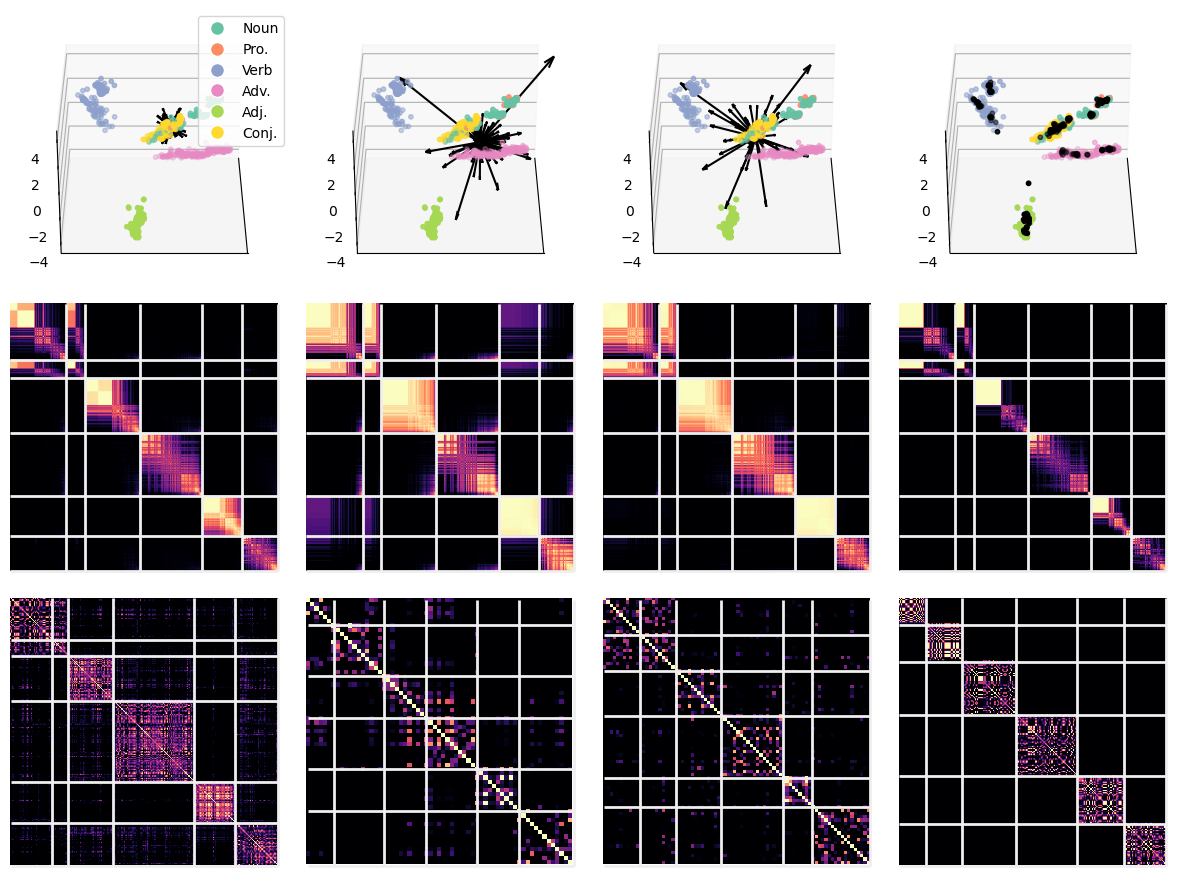

In [27]:
# fig, ax = plt.subplots(len(exptnames), 3, figsize=(3*3, 3*len(exptnames)))

fig = plt.figure(figsize=(3*4, 3*3))

ax1 = plt.subplot2grid((3, 4), (0, 0), rowspan=1, colspan=1, projection='3d')
ax2 = plt.subplot2grid((3, 4), (1, 0), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((3, 4), (2, 0), rowspan=1, colspan=1)

ax4 = plt.subplot2grid((3, 4), (0, 1), rowspan=1, colspan=1, projection='3d')
ax5 = plt.subplot2grid((3, 4), (1, 1), rowspan=1, colspan=1)
ax6 = plt.subplot2grid((3, 4), (2, 1), rowspan=1, colspan=1)

ax7 = plt.subplot2grid((3, 4), (0, 2), rowspan=1, colspan=1, projection='3d')
ax8 = plt.subplot2grid((3, 4), (1, 2), rowspan=1, colspan=1)
ax9 = plt.subplot2grid((3, 4), (2, 2), rowspan=1, colspan=1)

ax10 = plt.subplot2grid((3, 4), (0, 3), rowspan=1, colspan=1, projection='3d')
ax11 = plt.subplot2grid((3, 4), (1, 3), rowspan=1, colspan=1)
ax12 = plt.subplot2grid((3, 4), (2, 3), rowspan=1, colspan=1)

ax = np.array([[ax1, ax4, ax7, ax10], [ax2, ax5, ax8, ax11], [ax3, ax6, ax9, ax12]])
ax = ax.T
cmap = plt.cm.Set2
colors_concepts = [cmap.colors[i] for i in range(num_concepts)]

for i in range(len(exptnames)):
    ax[i,0].scatter(data_subset_pca[:,0], data_subset_pca[:,1], data_subset_pca[:,2], \
        c=[colors_concepts[int(labels_subset[i].item())] for i in range(len(labels_subset))], s=10)
    ax[i,0].view_init(elev=30, azim=0)
    if i==len(exptnames)-1:
        ax[i,0].scatter(encweightspca[i][:,0], encweightspca[i][:,1], encweightspca[i][:,2], c='black', s=10)
        ax[i,0].view_init(elev=30, azim=0)
    else:
        ax[i,0].quiver(preencbiaspca[i][0,0]*np.ones((encweightspca[i].shape[0],)), \
            preencbiaspca[i][0,1]*np.ones((encweightspca[i].shape[0],)), \
                preencbiaspca[i][0,2]*np.ones((encweightspca[i].shape[0],)), \
                    encweightspca[i][:,0], encweightspca[i][:,1], encweightspca[i][:,2], \
                        color='black', length=0.015, arrow_length_ratio=0.1)
    ax[i, 1].imshow(Cdata_all[i], cmap='magma', vmin=0, vmax=1)
    ax[i,1].hlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[1], colors='#EFEFEF', linewidth=2)
    ax[i,1].vlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[0], colors='#EFEFEF', linewidth=2)
    ax[i, 2].imshow(Clatent_all[i], cmap='magma', vmin=0, vmax=1)
    ax[i,2].hlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[1], colors='#EFEFEF', linewidth=2)
    ax[i,2].vlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[0], colors='#EFEFEF', linewidth=2)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    if i==0:
        #add custom legend with points with concept names and colors
        custom_points = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap.colors[c], markersize=10) for c in range(num_concepts)]
        ax[i,0].legend(custom_points, concept_names, loc='upper right')

plt.tight_layout()

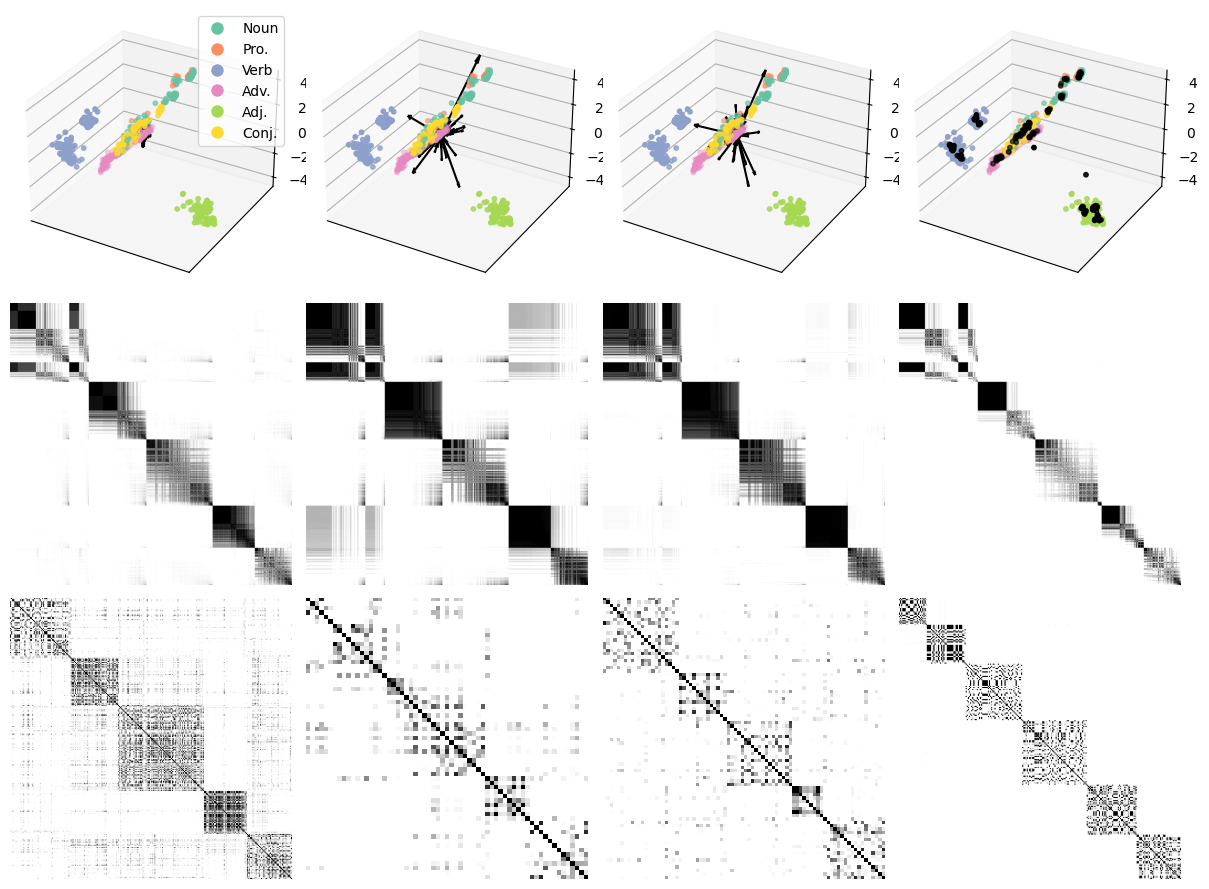

In [16]:
# fig, ax = plt.subplots(len(exptnames), 3, figsize=(3*3, 3*len(exptnames)))

fig = plt.figure(figsize=(3*4, 3*3))

ax1 = plt.subplot2grid((3, 4), (0, 0), rowspan=1, colspan=1, projection='3d')
ax2 = plt.subplot2grid((3, 4), (1, 0), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((3, 4), (2, 0), rowspan=1, colspan=1)

ax4 = plt.subplot2grid((3, 4), (0, 1), rowspan=1, colspan=1, projection='3d')
ax5 = plt.subplot2grid((3, 4), (1, 1), rowspan=1, colspan=1)
ax6 = plt.subplot2grid((3, 4), (2, 1), rowspan=1, colspan=1)

ax7 = plt.subplot2grid((3, 4), (0, 2), rowspan=1, colspan=1, projection='3d')
ax8 = plt.subplot2grid((3, 4), (1, 2), rowspan=1, colspan=1)
ax9 = plt.subplot2grid((3, 4), (2, 2), rowspan=1, colspan=1)

ax10 = plt.subplot2grid((3, 4), (0, 3), rowspan=1, colspan=1, projection='3d')
ax11 = plt.subplot2grid((3, 4), (1, 3), rowspan=1, colspan=1)
ax12 = plt.subplot2grid((3, 4), (2, 3), rowspan=1, colspan=1)

ax = np.array([[ax1, ax4, ax7, ax10], [ax2, ax5, ax8, ax11], [ax3, ax6, ax9, ax12]])
ax = ax.T
cmap = plt.cm.Set2
colors_concepts = [cmap.colors[i] for i in range(num_concepts)]

for i in range(len(exptnames)):
    ax[i,0].scatter(data_subset_pca[:,0], data_subset_pca[:,1], data_subset_pca[:,2], \
        c=[colors_concepts[int(labels_subset[i].item())] for i in range(len(labels_subset))], s=10)
    # ax[i,0].view_init(elev=30, azim=45)
    if i==len(exptnames)-1:
        ax[i,0].scatter(encweightspca[i][:,0], encweightspca[i][:,1], encweightspca[i][:,2], c='black', s=10)
        # ax[i,0].view_init(elev=30, azim=45)
    else:
        ax[i,0].quiver(torch.zeros((encweightspca[i].shape[0],)), \
            torch.zeros((encweightspca[i].shape[0],)), \
                torch.zeros((encweightspca[i].shape[0],)), \
                    encweightspca[i][:,0], encweightspca[i][:,1], encweightspca[i][:,2], \
                        color='black', length=0.01, arrow_length_ratio=0.1)
    ax[i, 1].imshow(Cdata_all[i], cmap='binary', vmin=0, vmax=1)
    # ax[i,1].hlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[1], colors='#EFEFEF', linewidth=2)
    # ax[i,1].vlines(np.cumsum(numpoints_perconc), 0, Cdata_all[i].shape[0], colors='#EFEFEF', linewidth=2)
    ax[i, 2].imshow(Clatent_all[i], cmap='binary', vmin=0, vmax=1)
    # ax[i,2].hlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[1], colors='#EFEFEF', linewidth=2)
    # ax[i,2].vlines(np.cumsum(numlatents_perconc_all[i]), 0, Clatent_all[i].shape[0], colors='#EFEFEF', linewidth=2)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    if i==0:
        #add custom legend with points with concept names and colors
        custom_points = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap.colors[c], markersize=10) for c in range(num_concepts)]
        ax[i,0].legend(custom_points, concept_names, loc='upper right')

plt.tight_layout()

Notes:
1. dimension = 128
2. #sae latents = 256
3. pos_acts contains data (model activations) for different parts of speech
4. acts_corrmap is data-data correlations
5. latents_corrmap is latent-latent correlations
6. latents_to_acts has latent representations for diff data